# Melanoma Prediction Using Tabular Data
In this solely based on feature engineering and using Machine learning Model to detect Skin Cancer. No Deep Learning Model has been used here.

**Special Thank to [oliver](https://www.kaggle.com/ogrellier) for sharing some key features in the data**

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
from tqdm import tqdm
import seaborn as sns
sns.set(style = 'dark')
import matplotlib.pyplot as plt

In [2]:
train_files_dir = glob('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/*')
test_files_dir = glob('/kaggle/input/siim-isic-melanoma-classification/jpeg/test/*')

In [3]:
train_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

In [4]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Label Encoding

## Sex

In [6]:
train_df['sex'].fillna('unkown',inplace = True) # missing value

In [7]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [8]:
train_df['sex_enc'] = enc.fit_transform(train_df.sex.astype('str'))
test_df['sex_enc'] = enc.transform(test_df.sex.astype('str'))

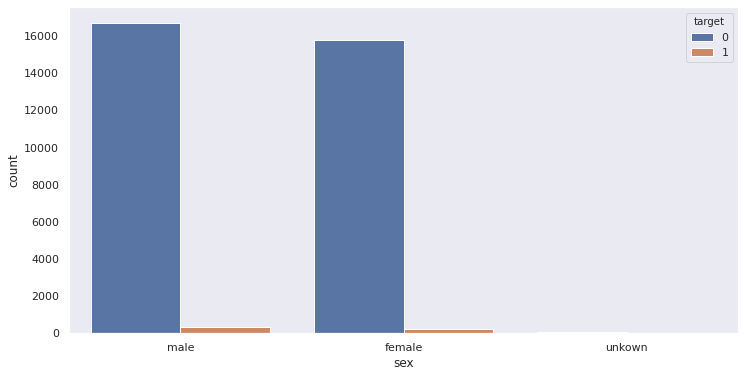

In [9]:
plt.figure(figsize = (12,6))
sns.countplot(x = 'sex', hue = 'target', data = train_df)

In [10]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_enc
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,1
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0


In [11]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1
2,ISIC_0058510,IP_7960270,female,55.0,torso,0
3,ISIC_0073313,IP_6375035,female,50.0,torso,0
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0


## Anatom_site_general_challenge

In [12]:
test_df.anatom_site_general_challenge = test_df.anatom_site_general_challenge.fillna('unknown')
train_df.anatom_site_general_challenge = train_df.anatom_site_general_challenge.fillna('unknown')

In [13]:
train_df['anatom_enc']= enc.fit_transform(train_df.anatom_site_general_challenge.astype('str'))
test_df['anatom_enc']= enc.transform(test_df.anatom_site_general_challenge.astype('str'))

In [14]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_enc,anatom_enc
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,1,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,0,1
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0,6


In [15]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,anatom_enc
0,ISIC_0052060,IP_3579794,male,70.0,unknown,1,5
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,1
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,4
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,4
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,1


# Age

In [16]:
train_df['age_approx'] = train_df['age_approx'].fillna(train_df['age_approx'].mode().values[0])
test_df['age_approx']  = test_df['age_approx'].fillna(test_df['age_approx'].mode().values[0]) # Test data doesn't have any NaN in age_approx

In [17]:
train_df['age_enc']= enc.fit_transform(train_df['age_approx'].astype('str'))
test_df['age_enc']= enc.transform(test_df['age_approx'].astype('str'))

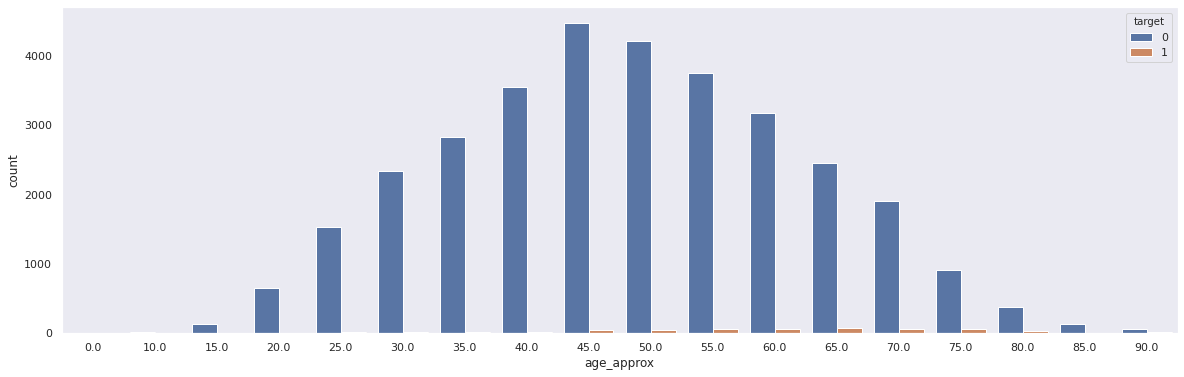

In [18]:
plt.figure(figsize = (20,6))
sns.countplot(x = 'age_approx', hue = 'target', data = train_df)

In [19]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_enc,anatom_enc,age_enc
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,1,0,8
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6,8
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,0,1,9
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,0,8
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0,6,10


In [20]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,anatom_enc,age_enc
0,ISIC_0052060,IP_3579794,male,70.0,unknown,1,5,13
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,1,7
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,4,10
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,4,9
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,1,8


# Images Per Patient

In [21]:
train_df['n_images'] = train_df.patient_id.map(train_df.groupby(['patient_id']).image_name.count())
test_df['n_images'] = test_df.patient_id.map(test_df.groupby(['patient_id']).image_name.count())

# Categorize Number of Images Per Patient

In [22]:
from sklearn.preprocessing import KBinsDiscretizer
categorize = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'uniform')
train_df['n_images_enc'] = categorize.fit_transform(train_df['n_images'].values.reshape(-1, 1)).astype(int).squeeze()
test_df['n_images_enc'] = categorize.transform(test_df['n_images'].values.reshape(-1, 1)).astype(int).squeeze()

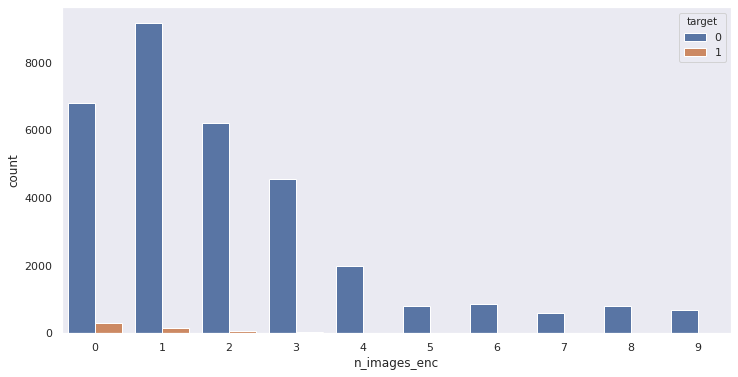

In [23]:
plt.figure(figsize = (12,6))
sns.countplot(x = 'n_images_enc', hue = 'target', data = train_df)

In [24]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_enc,anatom_enc,age_enc,n_images,n_images_enc
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,1,0,8,115,9
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6,8,24,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,0,1,9,5,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,0,8,22,1
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0,6,10,20,1


In [25]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,anatom_enc,age_enc,n_images,n_images_enc
0,ISIC_0052060,IP_3579794,male,70.0,unknown,1,5,13,240,9
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,1,7,46,3
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,4,10,28,2
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,4,9,38,3
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,1,8,29,2


# Image Size 

In [26]:
train_images = train_df['image_name'].values
train_sizes = np.zeros(train_images.shape[0])
for i, img_path in enumerate(tqdm(train_images)):
    train_sizes[i] = os.path.getsize(os.path.join('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/', f'{img_path}.jpg'))
    
train_df['image_size'] = train_sizes


test_images = test_df['image_name'].values
test_sizes = np.zeros(test_images.shape[0])
for i, img_path in enumerate(tqdm(test_images)):
    test_sizes[i] = os.path.getsize(os.path.join('/kaggle/input/siim-isic-melanoma-classification/jpeg/test/', f'{img_path}.jpg'))
    
test_df['image_size'] = test_sizes

100%|██████████| 10982/10982 [00:03<00:00, 3326.37it/s]


# Scaling Image Size

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scale = MinMaxScaler()
train_df['image_size_scaled'] = scale.fit_transform(train_df['image_size'].values.reshape(-1, 1))
test_df['image_size_scaled'] = scale.transform(test_df['image_size'].values.reshape(-1, 1))

# Categorize Image Size

In [28]:
from sklearn.preprocessing import KBinsDiscretizer
categorize = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'uniform')
train_df['image_size_enc'] = categorize.fit_transform(train_df.image_size_scaled.values.reshape(-1, 1)).astype(int).squeeze()
test_df['image_size_enc'] = categorize.transform(test_df.image_size_scaled.values.reshape(-1, 1)).astype(int).squeeze()

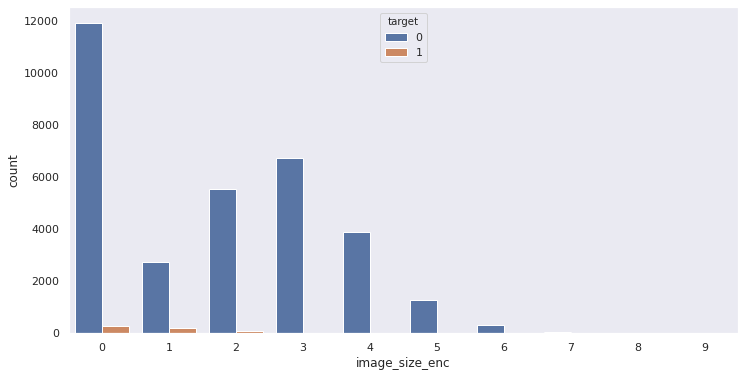

In [29]:
plt.figure(figsize = (12,6))
sns.countplot(x = 'image_size_enc', hue = 'target', data = train_df)

In [30]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_enc,anatom_enc,age_enc,n_images,n_images_enc,image_size,image_size_scaled,image_size_enc
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,1,0,8,115,9,1840868.0,0.525522,5
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6,8,24,1,1911615.0,0.545893,5
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,0,1,9,5,0,138515.0,0.035336,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,0,8,22,1,215755.0,0.057577,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0,6,10,20,1,1649943.0,0.470546,4


In [31]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,anatom_enc,age_enc,n_images,n_images_enc,image_size,image_size_scaled,image_size_enc
0,ISIC_0052060,IP_3579794,male,70.0,unknown,1,5,13,240,9,2097525.0,0.599425,5
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,1,7,46,3,1167934.0,0.331753,3
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,4,10,28,2,1148771.0,0.326235,3
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,4,9,38,3,1190077.0,0.338129,3
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,1,8,29,2,154448.0,0.039924,0


# Mean Color(Used previously saved data)

train_df['mean_color'] = train_mean_color.values
test_df['mean_color'] = test_mean_color.values

# Categorize Mean Color

from sklearn.preprocessing import KBinsDiscretizer
categorize = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'uniform')
train_df['mean_color_enc'] = categorize.fit_transform(train_df['mean_color'].values.reshape(-1, 1)).astype(int).squeeze()
test_df['mean_color_enc'] = categorize.transform(test_df['mean_color'].values.reshape(-1, 1)).astype(int).squeeze()

plt.figure(figsize = (12,6))
sns.countplot(x = 'mean_color_enc', hue = 'target', data = train_df)

# Min-Max age of Patient

In [32]:
train_df['age_id_min']  = train_df['patient_id'].map(train_df.groupby(['patient_id']).age_approx.min())
train_df['age_id_max']  = train_df['patient_id'].map(train_df.groupby(['patient_id']).age_approx.max())

test_df['age_id_min']  = test_df['patient_id'].map(test_df.groupby(['patient_id']).age_approx.min())
test_df['age_id_max']  = test_df['patient_id'].map(test_df.groupby(['patient_id']).age_approx.max())

# Mean Encoding

## Plotting Barplot with number

In [33]:
def show_bar_plot(df, figsize = (12,6)):
 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    
    def show_values_on_bars(axs, h_v="v", space=0.4, v_space = 0.02, figsize = (12,6)):
        def _show_on_single_plot(ax):
            if h_v == "v":
                for p in ax.patches:
                    _x = p.get_x() + p.get_width() / 2
                    _y = p.get_y() + p.get_height()+ v_space
                    value = float(p.get_height())
                    ax.text(_x, _y, f'{value:.1f}', ha="center") 
            elif h_v == "h":
                for p in ax.patches:
                    _x = p.get_x() + p.get_width() + float(space)
                    _y = p.get_y() + p.get_height()+ v_space
                    value = int(p.get_width())
                    ax.text(_x, _y, value, ha="left")

        if isinstance(axs, np.ndarray):
            for idx, ax in np.ndenumerate(axs):
                _show_on_single_plot(ax)
        else:
            _show_on_single_plot(axs)
            

#     fig = plt.gcf()
#     fig.set_size_inches(12, 8)
    plt.figure(figsize = figsize)
    sns.set()
    plt.title('Probability')

    prob = df*100
    pal = sns.color_palette(palette='Blues_r', n_colors=len(prob))
    rank = prob.values.argsort().argsort() 
    #g=sns.barplot(x='day',y='tip',data=groupedvalues, palette=np.array(pal[::-1])[rank])
    br = sns.barplot(prob.index, prob.values, palette=np.array(pal[::-1])[rank])
    show_values_on_bars(br, "v", .50)
    plt.show()          

In [34]:
def kdeplot( df,col_name, figsize = (12,6)):

    plt.figure(figsize = figsize)
    sns.kdeplot(df[col_name][df.target==0], shade = True, color = 'b', label = '0')
    sns.kdeplot(df[col_name][df.target==1], shade = True, color = 'r', label = '1')
    plt.show()

## Age

In [35]:
train_df['age_approx_mean_enc'] = train_df['age_approx'].map(train_df.groupby(['age_approx'])['target'].mean())
test_df['age_approx_mean_enc'] = test_df['age_approx'].map(train_df.groupby(['age_approx'])['target'].mean())

## Probability of melanoma with respect to Age

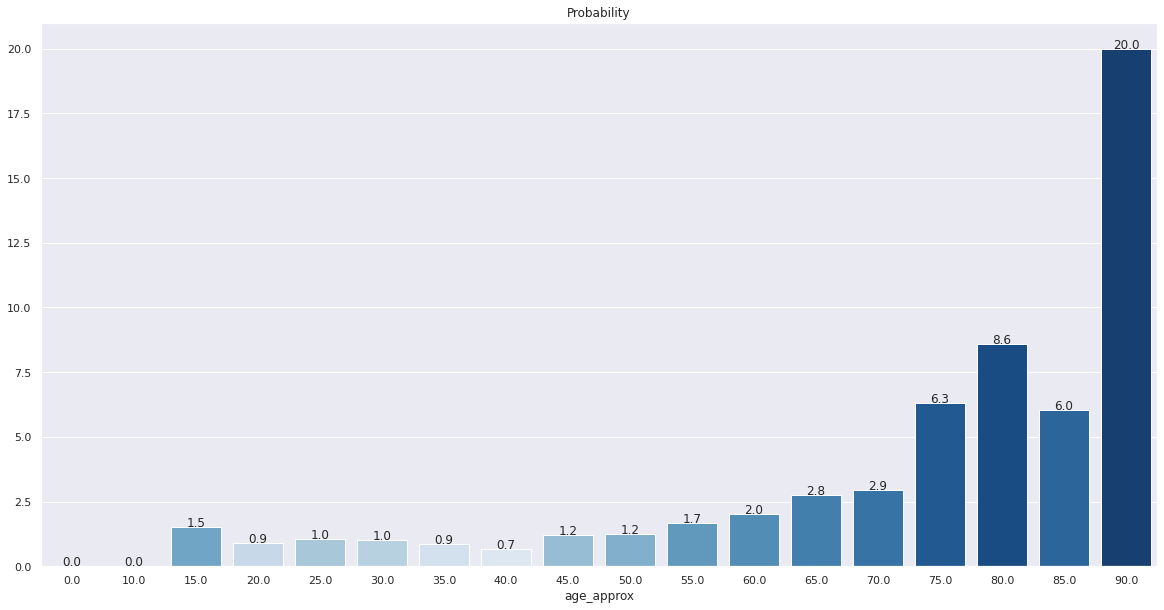

In [36]:
show_bar_plot(train_df.groupby(['age_approx'])['target'].mean(), (20,10))

## Before Mean Encoding

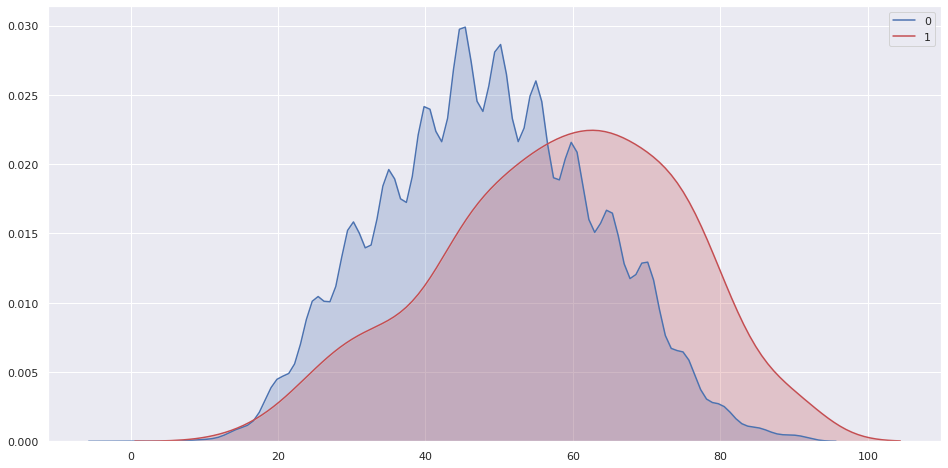

In [37]:
col_name = 'age_approx'
kdeplot(train_df,col_name, figsize = (16,8))

## After Mean Encoding

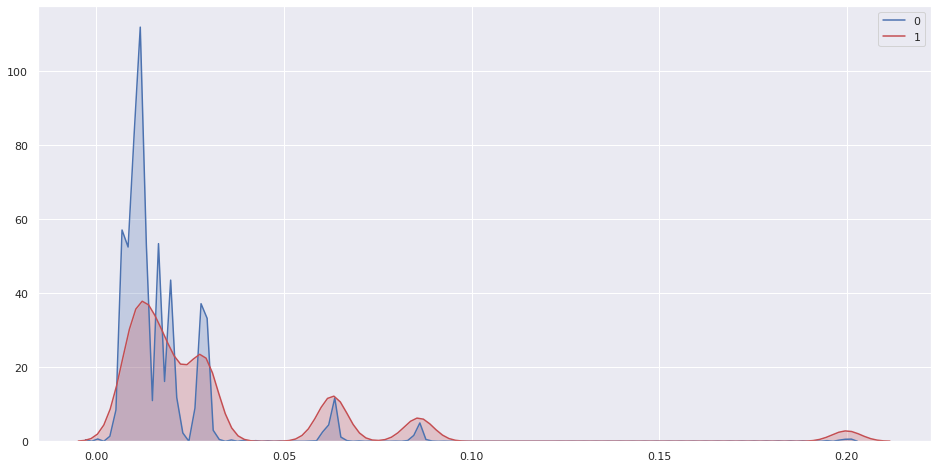

In [38]:
col_name = 'age_approx_mean_enc'
kdeplot(train_df,col_name, figsize = (16,8))

## Sex

In [39]:
train_df['sex_mean_enc'] = train_df.sex_enc.map(train_df.groupby(['sex_enc'])['target'].mean())
test_df['sex_mean_enc'] = test_df.sex_enc.map(train_df.groupby(['sex_enc'])['target'].mean())

## Probability of melanoma with respect to Sex

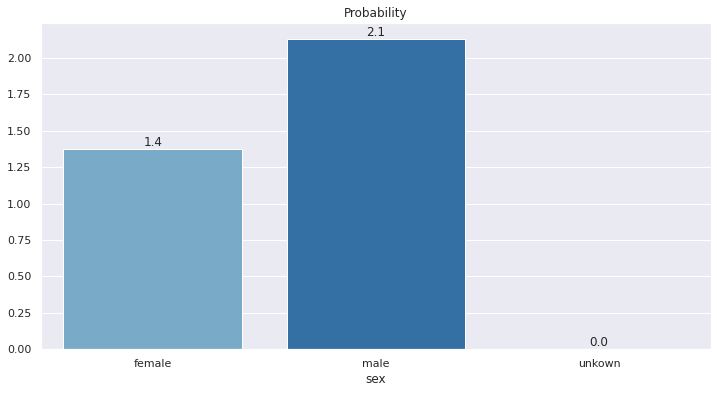

In [40]:
show_bar_plot(train_df.groupby(['sex'])['target'].mean())

## Before Mean Encoding

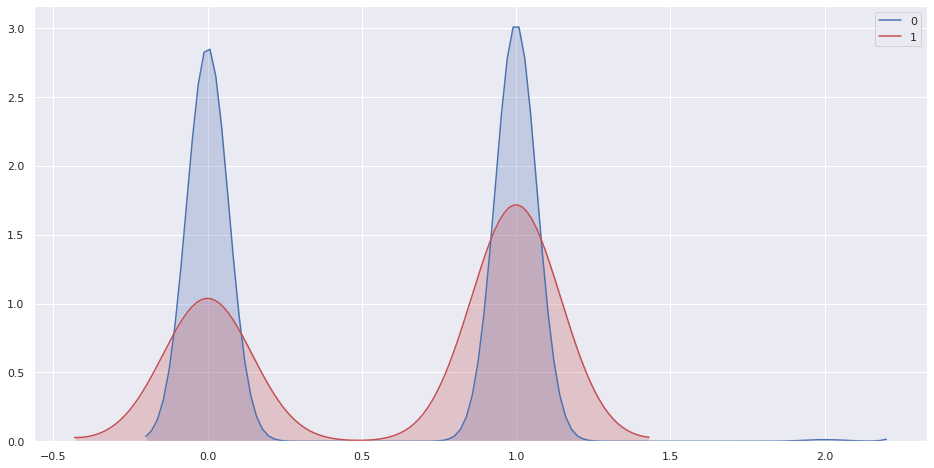

In [41]:
col_name = 'sex_enc'
kdeplot(train_df,col_name, figsize = (16,8))

## After Mean Encoding

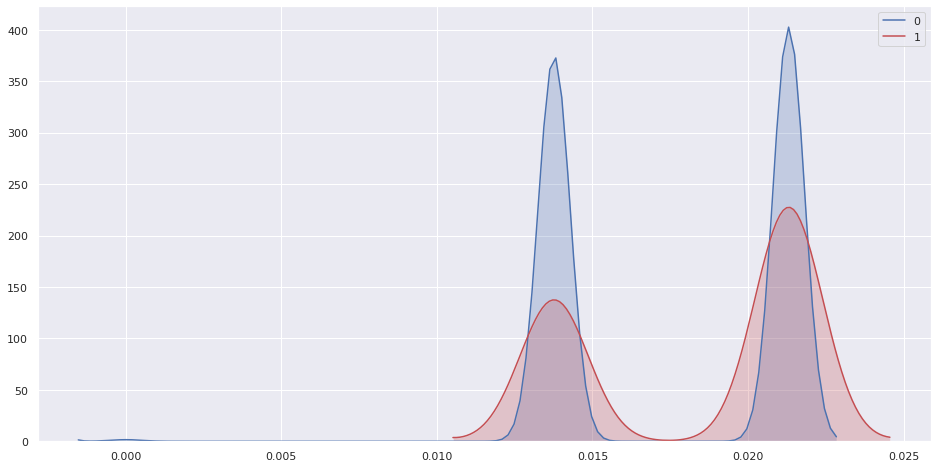

In [42]:
col_name = 'sex_mean_enc'
kdeplot(train_df,col_name, figsize = (16,8))

## n_images

In [43]:
train_df['n_images_mean_enc'] = train_df['n_images_enc'].map(train_df.groupby(['n_images_enc'])['target'].mean())
test_df['n_images_mean_enc'] = test_df['n_images_enc'].map(train_df.groupby(['n_images_enc'])['target'].mean())

## Probability of melanoma with respect to Number of Image per Patient

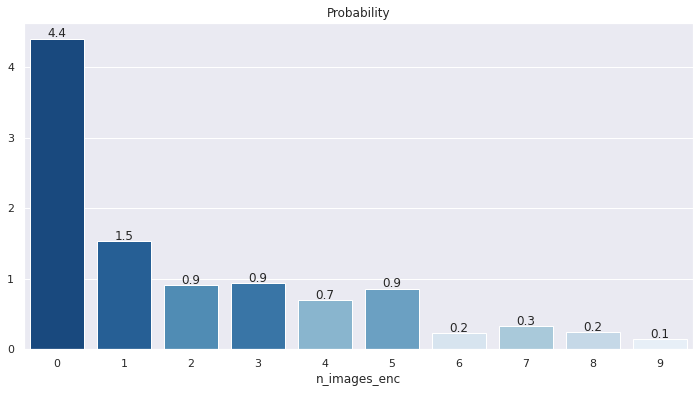

In [44]:
show_bar_plot(train_df.groupby(['n_images_enc'])['target'].mean())

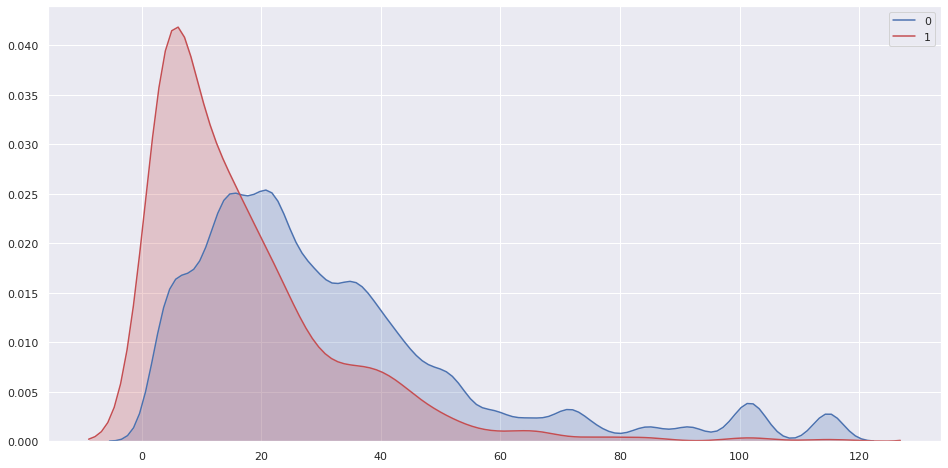

In [45]:
col_name = 'n_images'
kdeplot(train_df,col_name, figsize = (16,8))

## After Encoding

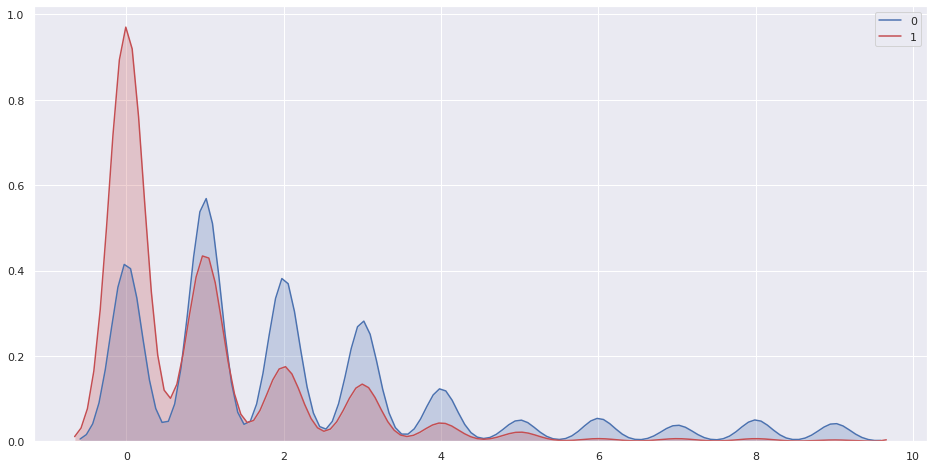

In [46]:
col_name = 'n_images_enc'
kdeplot(train_df,col_name, figsize = (16,8))

## After Mean Encoding

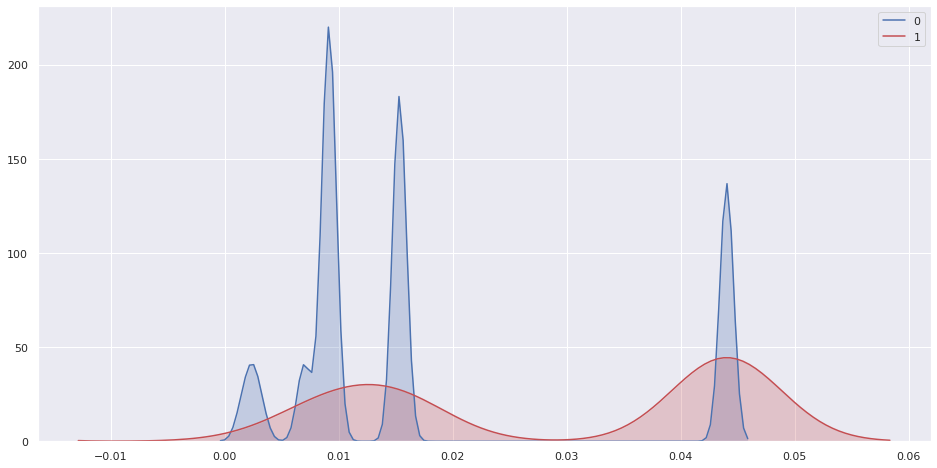

In [47]:
col_name = 'n_images_mean_enc'
kdeplot(train_df,col_name, figsize = (16,8))

## Image Size

In [48]:
train_df['image_size_mean_enc'] = train_df['image_size_enc'].map(train_df.groupby(['image_size_enc'])['target'].mean())
test_df['image_size_mean_enc'] = test_df['image_size_enc'].map(train_df.groupby(['image_size_enc'])['target'].mean())

## Probability of melanoma with respect to Image Size

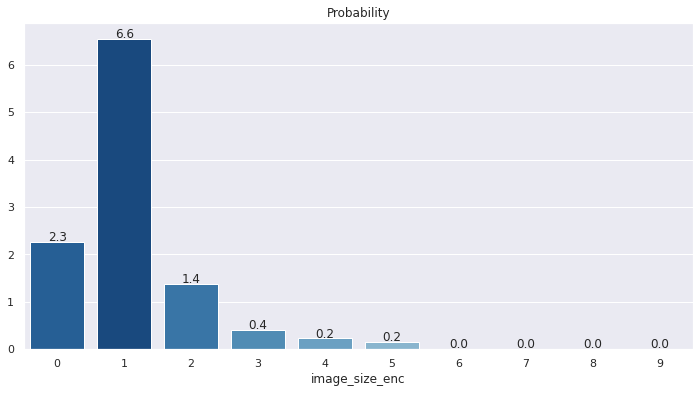

In [49]:
show_bar_plot(train_df.groupby(['image_size_enc'])['target'].mean())

## After Encoding

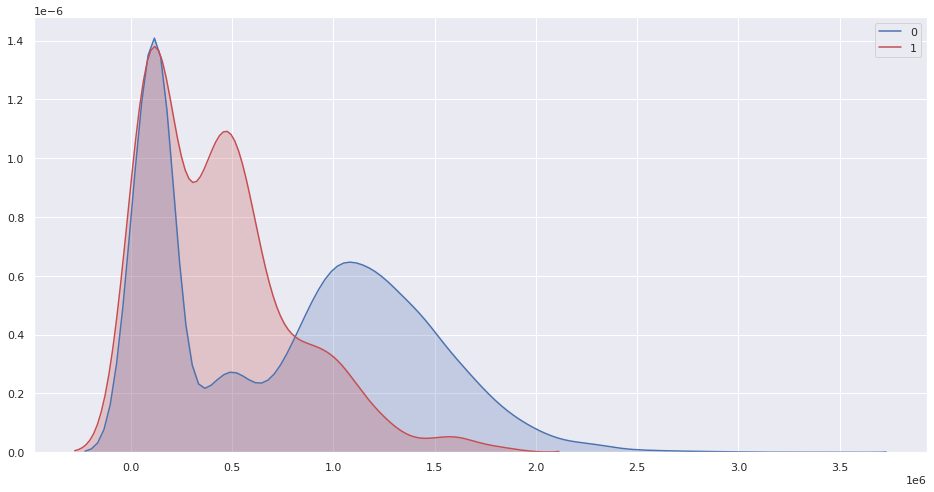

In [50]:
col_name = 'image_size'
kdeplot(train_df,col_name, figsize = (16,8))

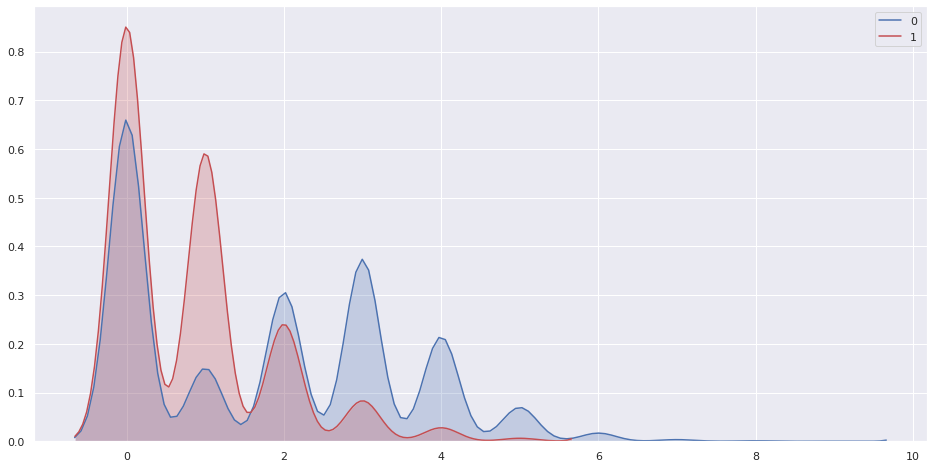

In [51]:
col_name = 'image_size_enc'
kdeplot(train_df,col_name, figsize = (16,8))

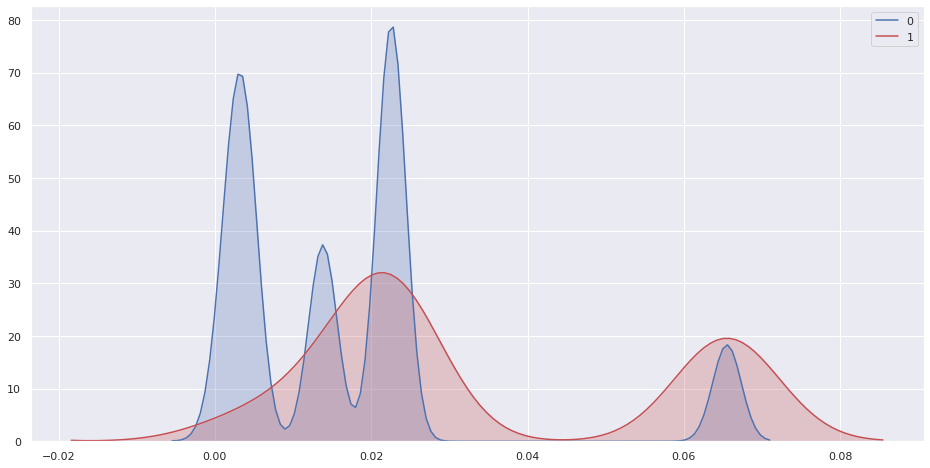

In [52]:
col_name = 'image_size_mean_enc'
kdeplot(train_df,col_name, figsize = (16,8))

## Anatom General Challenge

In [53]:
train_df['anatom_mean_enc'] = train_df['anatom_enc'].map(train_df.groupby(['anatom_enc'])['target'].mean())
test_df['anatom_mean_enc'] = test_df['anatom_enc'].map(train_df.groupby(['anatom_enc'])['target'].mean())

## Probability of melanoma with respect to Anatom General Challege

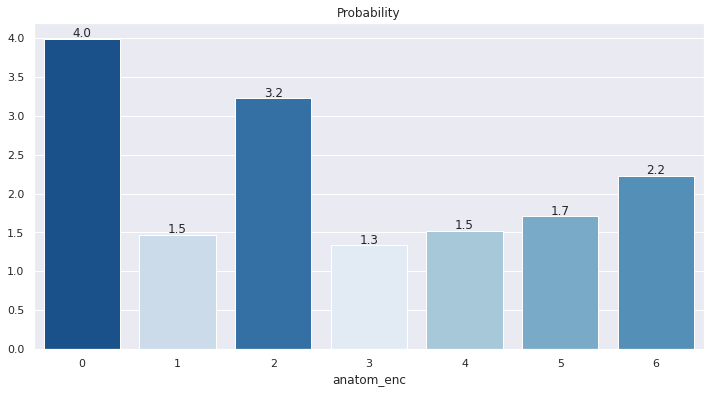

In [54]:
show_bar_plot(train_df.groupby(['anatom_enc'])['target'].mean())

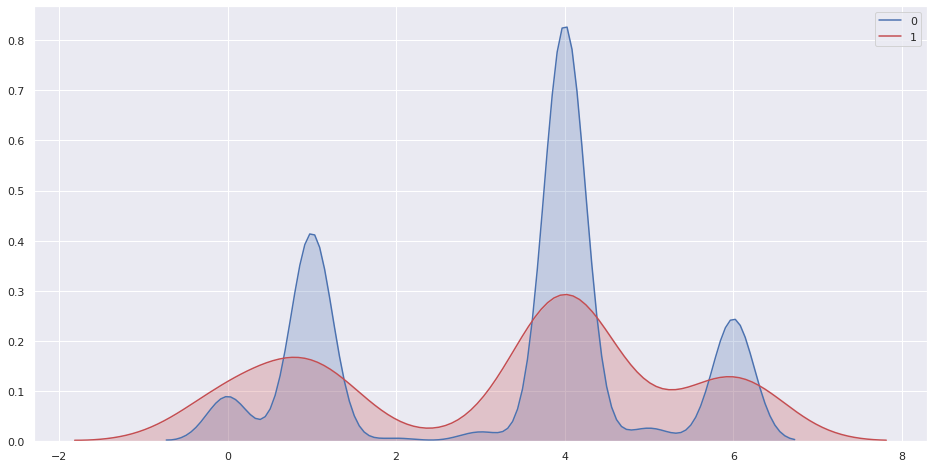

In [55]:
col_name = 'anatom_enc'
kdeplot(train_df,col_name, figsize = (16,8))

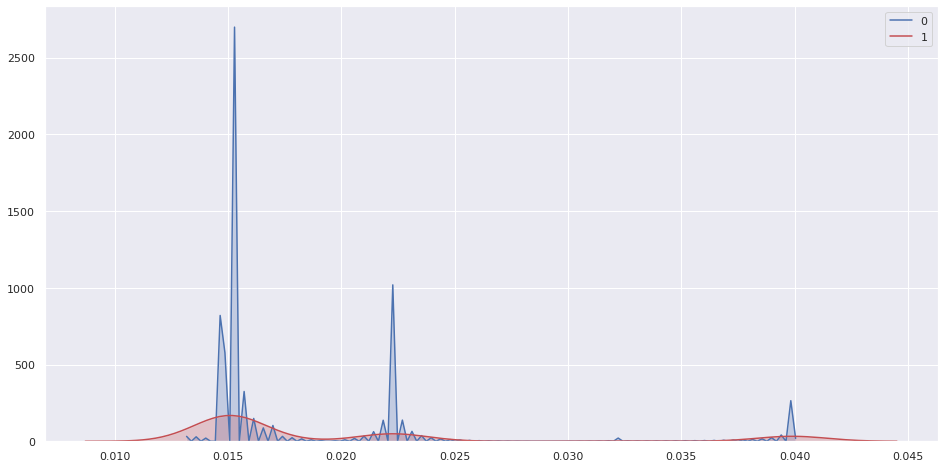

In [56]:
col_name = 'anatom_mean_enc'
kdeplot(train_df,col_name, figsize = (16,8))

# Mean Color

train_df['mean_color_mean_enc'] = train_df['mean_color_enc'].map(train_df.groupby(['mean_color_enc'])['target'].mean())
test_df['mean_color_mean_enc'] = test_df['mean_color_enc'].map(train_df.groupby(['mean_color_enc'])['target'].mean())

## Probability of melanoma with respect to Mean Color

show_bar_plot(train_df.groupby(['mean_color_enc'])['target'].mean())

## Before encoding

col_name = 'mean_color'
kdeplot(train_df,col_name, figsize = (16,8))

## After encoding

col_name = 'mean_color_enc'
kdeplot(train_df,col_name, figsize = (16,8))

## After Mean Encoding

col_name = 'mean_color_mean_enc'
kdeplot(train_df,col_name, figsize = (16,8))

# Correlation Matrix
We can extract some interesting features from Corr Matrix. I leave that to the reader to find out some tricky features from Corr Matrix. Let me know you find one. 

**Spoiler Alert:** You can easily get **.80** just playing with these features

In [57]:
corr = train_df.corr(method = 'pearson')
corr = corr.abs()
corr.style.background_gradient(cmap='inferno')

,age_approx,target,sex_enc,anatom_enc,age_enc,n_images,n_images_enc,image_size,image_size_scaled,image_size_enc,age_id_min,age_id_max,age_approx_mean_enc,sex_mean_enc,n_images_mean_enc,image_size_mean_enc,anatom_mean_enc
age_approx,1.000000,0.086454,0.107347,0.037486,0.999996,0.144709,0.143691,0.117391,0.117391,0.108494,0.957250,0.959817,0.703684,0.109969,0.158907,0.025104,0.045776
target,0.086454,1.000000,0.027604,0.006016,0.086457,0.079256,0.076253,0.076110,0.076110,0.077937,0.083256,0.094917,0.122859,0.029233,0.108641,0.130195,0.046229
sex_enc,0.107347,0.027604,1.000000,0.010275,0.107374,0.027094,0.036756,0.022612,0.022612,0.024759,0.087368,0.118657,0.058873,0.944291,0.007654,0.005221,0.001191
anatom_enc,0.037486,0.006016,0.010275,1.000000,0.037480,0.037277,0.038051,0.003726,0.003726,0.000435,0.026512,0.043488,0.038870,0.010303,0.027599,0.010043,0.130144
age_enc,0.999996,0.086457,0.107374,0.037480,1.000000,0.144743,0.143721,0.117373,0.117373,0.108478,0.957249,0.959820,0.703709,0.109997,0.158957,0.025100,0.045771
n_images,0.144709,0.079256,0.027094,0.037277,0.144743,1.000000,0.990364,0.333371,0.333371,0.335592,0.126816,0.161831,0.141531,0.021599,0.682297,0.273845,0.019490
n_images_enc,0.143691,0.076253,0.036756,0.038051,0.143721,0.990364,1.000000,0.336563,0.336563,0.338382,0.125089,0.162176,0.143677,0.028634,0.701879,0.269198,0.016745
image_size,0.117391,0.076110,0.022612,0.003726,0.117373,0.333371,0.336563,1.000000,1.000000,0.988079,0.250340,0.025233,0.032884,0.002883,0.271340,0.579640,0.101849
image_size_scaled,0.117391,0.076110,0.022612,0.003726,0.117373,0.333371,0.336563,1.000000,1.000000,0.988079,0.250340,0.025233,0.032884,0.002883,0.271340,0.579640,0.101849
image_size_enc,0.108494,0.077937,0.024759,0.000435,0.108478,0.335592,0.338382,0.988079,0.988079,1.000000,0.240375,0.023230,0.028068,0.004767,0.277636,0.598620,0.099827


In [58]:
# plt.figure(figsize = (20,20))
# sns.heatmap(corr, annot = True)

In [59]:
corr = test_df.corr(method = 'pearson')
corr = corr.abs()
corr.style.background_gradient(cmap='inferno')

,age_approx,sex_enc,anatom_enc,age_enc,n_images,n_images_enc,image_size,image_size_scaled,image_size_enc,age_id_min,age_id_max,age_approx_mean_enc,sex_mean_enc,n_images_mean_enc,image_size_mean_enc,anatom_mean_enc
age_approx,1.000000,0.108558,0.031231,1.000000,0.186017,0.112227,0.224045,0.224045,0.209334,0.955744,0.962991,0.750727,0.108558,0.004873,0.036431,0.040474
sex_enc,0.108558,1.000000,0.038253,0.108558,0.129366,0.087210,0.010895,0.010895,0.008392,0.094097,0.121522,0.107117,1.000000,0.088705,0.033835,0.001624
anatom_enc,0.031231,0.038253,1.000000,0.031231,0.104227,0.054750,0.024516,0.024516,0.027803,0.020885,0.039205,0.034185,0.038253,0.017992,0.010305,0.140541
age_enc,1.000000,0.108558,0.031231,1.000000,0.186017,0.112227,0.224045,0.224045,0.209334,0.955744,0.962991,0.750727,0.108558,0.004873,0.036431,0.040474
n_images,0.186017,0.129366,0.104227,0.186017,1.000000,0.888027,0.313482,0.313482,0.317614,0.171016,0.184580,0.070811,0.129366,0.540432,0.233997,0.030744
n_images_enc,0.112227,0.087210,0.054750,0.112227,0.888027,1.000000,0.342921,0.342921,0.351074,0.081643,0.121193,0.014488,0.087210,0.721907,0.250545,0.035971
image_size,0.224045,0.010895,0.024516,0.224045,0.313482,0.342921,1.000000,1.000000,0.988494,0.324340,0.120848,0.116623,0.010895,0.319986,0.575102,0.098954
image_size_scaled,0.224045,0.010895,0.024516,0.224045,0.313482,0.342921,1.000000,1.000000,0.988494,0.324340,0.120848,0.116623,0.010895,0.319986,0.575102,0.098954
image_size_enc,0.209334,0.008392,0.027803,0.209334,0.317614,0.351074,0.988494,0.988494,1.000000,0.304533,0.120122,0.106338,0.008392,0.334026,0.584276,0.096154
age_id_min,0.955744,0.094097,0.020885,0.955744,0.171016,0.081643,0.324340,0.324340,0.304533,1.000000,0.906706,0.718352,0.094097,0.047641,0.078226,0.049736


# Selecting Features

In [60]:
test_df.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'sex_enc', 'anatom_enc', 'age_enc',
       'n_images', 'n_images_enc', 'image_size', 'image_size_scaled',
       'image_size_enc', 'age_id_min', 'age_id_max', 'age_approx_mean_enc',
       'sex_mean_enc', 'n_images_mean_enc', 'image_size_mean_enc',
       'anatom_mean_enc'],
      dtype='object')

# I get rid of some features for best LB score

In [61]:
features = [
            'age_approx',
#             'age_enc',
#             'age_approx_mean_enc',
            'age_id_min',
            'age_id_max',
            'sex_enc',
#             'sex_mean_enc',
            'anatom_enc',
#             'anatom_mean_enc',
            'n_images',
#             'n_images_mean_enc',
#             'n_images_enc',
            'image_size_scaled',
#             'image_size_enc',
#             'image_size_mean_enc',
#             'mean_color',
#             'mean_color_enc', 
#             'mean_color_mean_enc'
           ]

In [62]:
X = train_df[features]
y = train_df['target']

X_test = test_df[features]

In [63]:
# Load libraries
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Training Xgboost
## Parameters were tunned using Gridsearch

In [64]:
model = XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.002, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=700, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

kfold = StratifiedKFold(n_splits=5, random_state=1001, shuffle=True)
cv_results = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc', verbose = 3)
cv_results.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.834, total=  15.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s


[CV] .................................... , score=0.815, total=  15.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.2s remaining:    0.0s


[CV] .................................... , score=0.836, total=  15.9s
[CV]  ................................................................
[CV] .................................... , score=0.856, total=  15.5s
[CV]  ................................................................
[CV] .................................... , score=0.830, total=  15.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished


0.8339546070357212

In [65]:
xgb = XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.002, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=700, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

xgb.fit(X,y)
pred_xgb = xgb.predict(X_test)

# Plot: Feature Importance

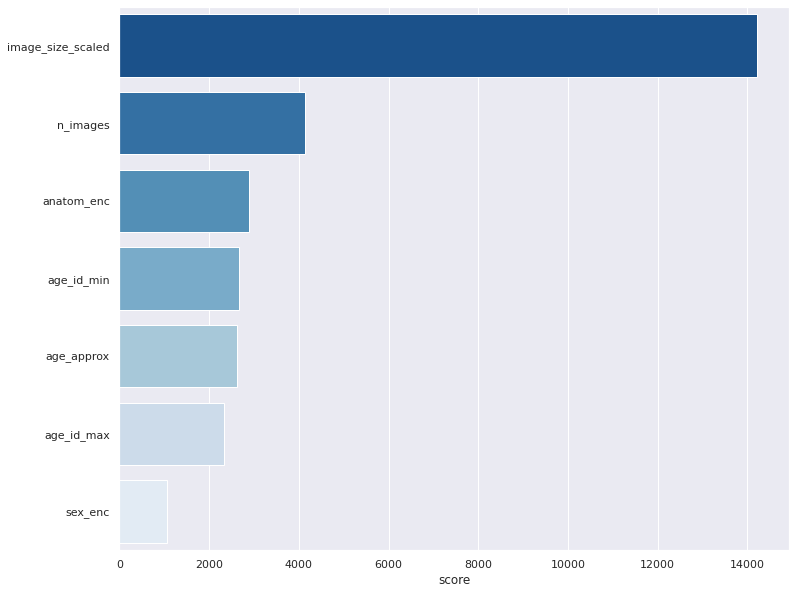

In [66]:
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize= (12,10))
sns.barplot(x = data.score , y = data.index, orient = 'h', palette = 'Blues_r')

# Dimension Reduction (PCA)

In [67]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame({'x_pca_0':X_pca[:,0],
             'x_pca_1':X_pca[:,1],
             'y':y})

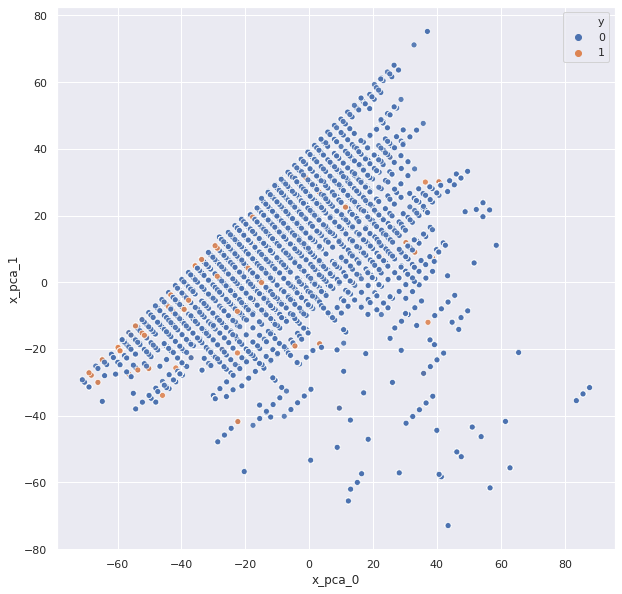

In [68]:
plt.figure(figsize = (10,10))
sns.scatterplot(
    x="x_pca_0", y="x_pca_1",
    hue="y",
    data=pca_df,
    legend="full",
    alpha=0.9
)

# Prediction

In [69]:
sub = pd.DataFrame({'image_name':test_df.image_name.values,
                    'target':pred_xgb})
sub.to_csv('submission.csv',index = False)

Though it is difficult to predict location of melanoma class from  plot but we look carefully we'll be able to notice that there are some regions where there is no melanoma class at all.

There might be two possible reasons behind LB score differing from the CV score .
1. Only 30% test data is used in Public LB
2. Our Model has been ovefitted

Please let me know if I can improve my results. 
## Thank You Very Much